## Max_Lag evaluation

In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX as ARIMA
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["figure.dpi"] = 200
plt.style.use("seaborn");plt.style.use("classic")
from itertools import product
%config InlineBackend.figure_format='retina'

In [2]:
def impute_outliers(df, q):
    df2 = df.copy()
    extreme_outliers = (df2 > df.quantile(q))
    df2[extreme_outliers] = np.nan
    df2.fillna(method="ffill", inplace=True)  
    return df2

In [20]:
#load data
with open("data_w", "rb") as f:
    data_w = pickle.load(f)
    
with open("data_2w", "rb") as f:
    data_2w = pickle.load(f)
    
with open("data_3w", "rb") as f:
    data_3w = pickle.load(f)
    
with open("data_m", "rb") as f:
    data_m = pickle.load(f)
    
cities = list(data_m.keys())

#Important Analysis parameters
starting_year = "2008"
target_vector = ['create', 'modify','tag_add',
            'tag_del', 'tag_change','loc_change',
            'new_mapper']

outlier_threshold = .99
detrend_data=False

for dat in [data_w, data_2w, data_3w, data_m]:
    for c in dat:
        dat[c] = impute_outliers(dat[c][target_vector][starting_year:], outlier_threshold).dropna()
        
# Leave out the very last year out for later testing
for c in data_w:
    data_w[c] = data_w[c][:-52]
for c in data_2w:
    data_2w[c] = data_2w[c][:-26]
for c in data_3w:
    data_3w[c] = data_3w[c][:-17]
for c in data_m:
    data_m[c] = data_m[c][:-12]

In [58]:
def pred_ARIMA(data, order=(2,1,1)):
    pred_vec = list()
    for col in data.columns:
        series = data[col].copy()
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        pred = output[0]
        pred_vec.append(pred)
    return np.array(pred_vec)
        

In [15]:
# This function aggregates the POI data, adds city dummies and shuffles the data.
# Then a model is fitted by using all of the data except for the testing periods
# Returns the Model
def global_training(frequency,model,max_lag, city_dummies):
    
    if frequency == "1w":
        data = copy(data_w)
        test_size = 52
    elif frequency == "2w":
        data = copy(data_2w)
        test_size = 26
    elif frequency == "3w":
        test_size = 17
        data = copy(data_3w)
    elif frequency == "4w":
        data = copy(data_m)
        test_size = 12
    cols = ['create', 'modify','tag_add',
            'tag_del', 'tag_change','loc_change',
            'new_mapper']

    dfs = list()
    for c in data: 
        df = data[c].copy()
        if model == "RF":
            #add additional temporal features for the RF
            for col in pd.get_dummies(df.index.month, prefix="month").columns:
                df[col] = pd.get_dummies(df.index.month, prefix="month")[col].values
            df["week_of_year"] = df.index.week
            df["day_of_month"] = df.index.day
            if city_dummies:
                df["city"] = [c for _ in range(len(df))]
        elif model == "VAR":
            df = df.diff().dropna()
        for col in cols:
            for l in range(1, max_lag+1):
                df[col+"(t-%s)" % l] = df[col].shift(l)
        df.reset_index(inplace=True)
        df.dropna(inplace=True)
        df = df[:-test_size]
        dfs.append(df)

    res = dfs[0].append(dfs[1])
    for frame in dfs[2:]:
        res = res.append(frame)
    del res["index"]
    res = res.reset_index()
    del res["index"]
    if city_dummies:
        encoded = pd.get_dummies(res["city"])
        del res["city"]
        res = res.join(encoded)
        
    #shuffle
    res = res.sample(frac=1).reset_index(drop=True)
    Y = res[cols]
    X = res[res.columns.difference(cols)]
    #print(X.shape, Y.shape)
    if model == "RF":
        Model = RandomForestRegressor(n_estimators=100,
                                       max_depth = None, n_jobs=-1,
                                        max_features = int(X.shape[1] / 3.))
    elif model == "VAR":
        Model = LinearRegression(n_jobs=-1)
        
    Model.fit(X, Y)
    
    return Model


In [67]:
def evaluate_lag(lag_range=[1,2,3,4]):
    results = list()
    for frequency in ["1w", "2w", "3w", "4w"]:
        for city in cities:
            for max_lag in lag_range:
                print("Evaluating Lag {} (Freq. = {}, City = {})".format(max_lag, frequency, city))
                if frequency == "1w":
                    data = data_w[city].copy()
                    test_size = 52
                    grf_dummy = global_training("1w", "RF",max_lag, city_dummies=True)
                    grf = global_training("1w", "RF",max_lag, city_dummies=False)
                    grf_dummy = global_training("1w", "RF",max_lag, city_dummies=True)
                elif frequency == "2w":
                    data = data_2w[city].copy()
                    test_size = 26
                elif frequency == "3w":
                    test_size = 17
                    data = data_3w[city].copy()
                elif frequency == "4w":
                    data = data_m[city].copy()
                    test_size = 12
                cols = target_vector
                data_rf = data.copy()
                data_orig = data.copy()
                data_var = data.copy().diff().dropna()

                pred_BL1 = data_orig[-test_size-1:].shift(1).dropna().values
                
                grf_dummy = global_training(frequency, "RF",max_lag, city_dummies=True)
                grf = global_training(frequency, "RF",max_lag, city_dummies=False)
                gvar = global_training(frequency, "VAR",max_lag, city_dummies=False)

                for col in data_rf:
                    for l in range(1, max_lag+1):
                        data_rf[col+"(t-%s)" % l] = data_rf[col].shift(l)
                data_rf.dropna(inplace=True)

                for col in data_var:
                    for l in range(1, max_lag+1):
                        data_var[col+"(t-%s)" % l] = data_var[col].shift(l)
                data_var.dropna(inplace=True)

                #add additional temporal features for the RF
                for col in pd.get_dummies(data_rf.index.month, prefix="month").columns:
                    data_rf[col] = pd.get_dummies(data_rf.index.month, prefix="month")[col].values
                data_rf["week_of_year"] = data_rf.index.week
                data_rf["day_of_month"] = data_rf.index.day
                
                data_rf_dummy = data_rf.copy()
                for ci in cities:
                    if ci == c:
                        data_rf_dummy[ci] = [ 1 for i in range(len(data_rf_dummy))  ]
                    else:
                        data_rf_dummy[ci] = [ 0 for i in range(len(data_rf_dummy))  ]
                        
                X_rf = data_rf[data_rf.columns.difference(cols)]
                X_rf_dummy = data_rf_dummy[data_rf_dummy.columns.difference(cols)]
                X_var = data_var[data_var.columns.difference(cols)]
                
                y_var = data_var[cols]
                y_rf = data_rf[cols]
                preds_var, preds_rf, preds_arima = list(), list(), list()
                var_true, rf_true = list(), list()
                var_index, rf_index = list(), list()
                gvar_preds, grf_dummy_preds, grf_preds = list(), list(), list()
                ## Rolling Pred with inital training
                for t in range(test_size):
                    if t!= test_size-1:
                        X_train_var, y_train_var = X_var[:-test_size+t], y_var[:-test_size+t]
                        X_test_var, y_test_var = X_var[-test_size+t:-test_size+t+1], y_var[-test_size+t:-test_size+t+1]

                        X_train_rf, y_train_rf = X_rf[:-test_size+t], y_rf[:-test_size+t]
                        X_test_rf, y_test_rf = X_rf[-test_size+t:-test_size+t+1], y_rf[-test_size+t:-test_size+t+1]
                        X_test_rf_dummy = X_rf_dummy[-test_size+t:-test_size+t+1]
                    else:
                        X_train_var, y_train_var = X_var[:-1], y_var[:-1]
                        X_test_var, y_test_var = X_var[-1:], y_var[-1:]

                        X_train_rf, y_train_rf = X_rf[:-1], y_rf[:-1]
                        X_test_rf, y_test_rf = X_rf[-1:], y_rf[-1:]
                        X_test_rf_dummy = X_rf_dummy[-1:]

                    var_true.append(y_test_var.values[0])
                    var_index.append(y_test_var.index[0])
                    #print("Train until :", X_train_var.index[-1], " Test on : ", X_test_var.index[0])
                    #print("\n - - - - - ")
                    rf_true.append(y_test_rf.values[0])
                    rf_index.append(y_test_rf.index[0])
                    #print("Train until :",X_train_rf.index[-1], " Test on : ", X_test_rf.index[0])
                    #print("\n - - - - - ")

                    #Train VAR and make one step pred
                    VAR = LinearRegression()
                    VAR.fit(X_train_var, y_train_var)
                    pred_var = VAR.predict(X_test_var)
                    preds_var.append(pred_var[0])
                    
                    #pred_gvar = gvar.predict(X_test_var)
                    #preds_gvar.append(pred_gvar)

                    #Train RF and make one step pred
                    RF = RandomForestRegressor(n_estimators=100,
                                               max_depth = None, n_jobs=-1, max_features = int(X_rf.shape[1] / 3.))
                    RF.fit(X_train_rf, y_train_rf)
                    pred_rf = RF.predict(X_test_rf)
                    preds_rf.append(pred_rf[0])
                    
                    #pred_grf_dummy = grf_dummy.predict(X_test_rf_dummy)
                    #pred_grf = grf.predict(X_test_rf)

                    #Train ARIMA and make one step pred
                    pred_arima = pred_ARIMA(data_orig[:-test_size+t], order=(max_lag, 1, 1))
                    preds_arima.append(pred_arima)

                rf_true = pd.DataFrame(rf_true, index=rf_index, columns=target_vector)
                var_true = pd.DataFrame(var_true, index=var_index, columns=target_vector)

               
                res = {"True" : pd.DataFrame(rf_true, columns=cols, index = data_orig[-test_size:].index),
                        "BL1" : pd.DataFrame(pred_BL1, columns=cols, index= data_orig[-test_size:].index),
                        "VAR" : pd.DataFrame(preds_var, columns=cols, index= data_orig[-test_size:].index),
                        "RF" : pd.DataFrame(preds_rf, columns=cols, index= data_orig[-test_size:].index),
                        "ARIMA" : pd.DataFrame(preds_arima, columns=cols, index= data_orig[-test_size:].index),
                        "lag" : max_lag, "city" : city, "freq" : frequency,
                        "GRF_D" : pd.DataFrame(grf_dummy.predict(X_rf_dummy[-test_size:]),
                                               columns=cols, index= data_orig[-test_size:].index),
                        "GRF" : pd.DataFrame(grf.predict(X_rf[-test_size:]),
                                             columns=cols, index= data_orig[-test_size:].index),
                        "GVAR" : pd.DataFrame(gvar.predict(X_var[-test_size:]),
                                             columns=cols, index= data_orig[-test_size:].index)}


                # Rescale predictions of models which used delta(x_t)
                for x in res:
                    if x in ["VAR", "GVAR"]:
                        #rescale using x_t = delta(x_t) + x_{t-1}
                        init_loc = data_orig.index.get_loc(res[x].index[0]) - 1
                        init_val = data_orig.iloc[init_loc]
                        res[x].iloc[0] = res[x].iloc[0] + init_val
                        for i in range(1, len(res[x])):
                            res[x].iloc[i] = res[x].iloc[i] + data_orig.iloc[init_loc+i]
                results.append(res)
    return results

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    results = evaluate_lag()

Evaluating Lag 1 (Freq. = 1w, City = Rome)
Evaluating Lag 2 (Freq. = 1w, City = Rome)
Evaluating Lag 3 (Freq. = 1w, City = Rome)
Evaluating Lag 4 (Freq. = 1w, City = Rome)
Evaluating Lag 1 (Freq. = 1w, City = Berlin)
Evaluating Lag 2 (Freq. = 1w, City = Berlin)
Evaluating Lag 3 (Freq. = 1w, City = Berlin)
Evaluating Lag 4 (Freq. = 1w, City = Berlin)
Evaluating Lag 1 (Freq. = 1w, City = Sao Paulo)
Evaluating Lag 2 (Freq. = 1w, City = Sao Paulo)
Evaluating Lag 3 (Freq. = 1w, City = Sao Paulo)
Evaluating Lag 4 (Freq. = 1w, City = Sao Paulo)
Evaluating Lag 1 (Freq. = 1w, City = New York)
Evaluating Lag 2 (Freq. = 1w, City = New York)
Evaluating Lag 3 (Freq. = 1w, City = New York)
Evaluating Lag 4 (Freq. = 1w, City = New York)
Evaluating Lag 1 (Freq. = 1w, City = Sydney)
Evaluating Lag 2 (Freq. = 1w, City = Sydney)
Evaluating Lag 3 (Freq. = 1w, City = Sydney)
Evaluating Lag 4 (Freq. = 1w, City = Sydney)
Evaluating Lag 1 (Freq. = 1w, City = Stockholm)
Evaluating Lag 2 (Freq. = 1w, City = Sto

In [ ]:

lag_results = list()
for res in results:
    RMSE_rf = np.sqrt(((res["True"] - res["RF"])**2).mean())
    RMSE_grf = np.sqrt(((res["True"] - res["GRF"])**2).mean())
    RMSE_grf_d = np.sqrt(((res["True"] - res["GRF_D"])**2).mean())
    RMSE_var = np.sqrt(((res["True"] - res["VAR"])**2).mean())
    RMSE_gvar = np.sqrt(((res["True"] - res["GVAR"])**2).mean())
    RMSE_bl1 = np.sqrt(((res["True"] - res["BL1"])**2).mean())
    RMSE_arima = np.sqrt(((res["True"] - res["ARIMA"])**2).mean())
    df = pd.DataFrame([_.to_list() for _ in [RMSE_var, RMSE_rf, RMSE_bl1, RMSE_arima,RMSE_gvar, RMSE_grf,RMSE_grf_d]],
                           columns = target_vector,
                           index=["VAR", "RF", "BL1", "ARIMA","GVAR", "GRF", "GRF_D"])
    df.index.name = "Model"
    for model in df.index:
        normalized_mean = (df / df.loc["BL1"]).loc[model].mean()
        if model != "BL1":
            lag_results.append({"model" : model, "E" : normalized_mean, "lag" : res["lag"], "city" : res["city"], "freq":res["freq"]})
        
lag_results = pd.DataFrame(lag_results)
#search for the error minimizing lag per model and frequency
dat = list()
for model in lag_results["model"].unique():
    for freq in lag_results["freq"].unique():
        for lag in lag_results["lag"].unique():
            df = lag_results[(lag_results["model"] == model)&(lag_results["freq"] == freq)&(lag_results["lag"] == lag)]
            dat.append({"lag" : lag, "model" :model, "freq" : freq, "mean" : df.E.mean(), "std" : df.E.std() })
dat = pd.DataFrame(dat)

In [61]:
import seaborn as sns

Text(0.5, 1.0, 'Lag Evaluation for Random Forest')

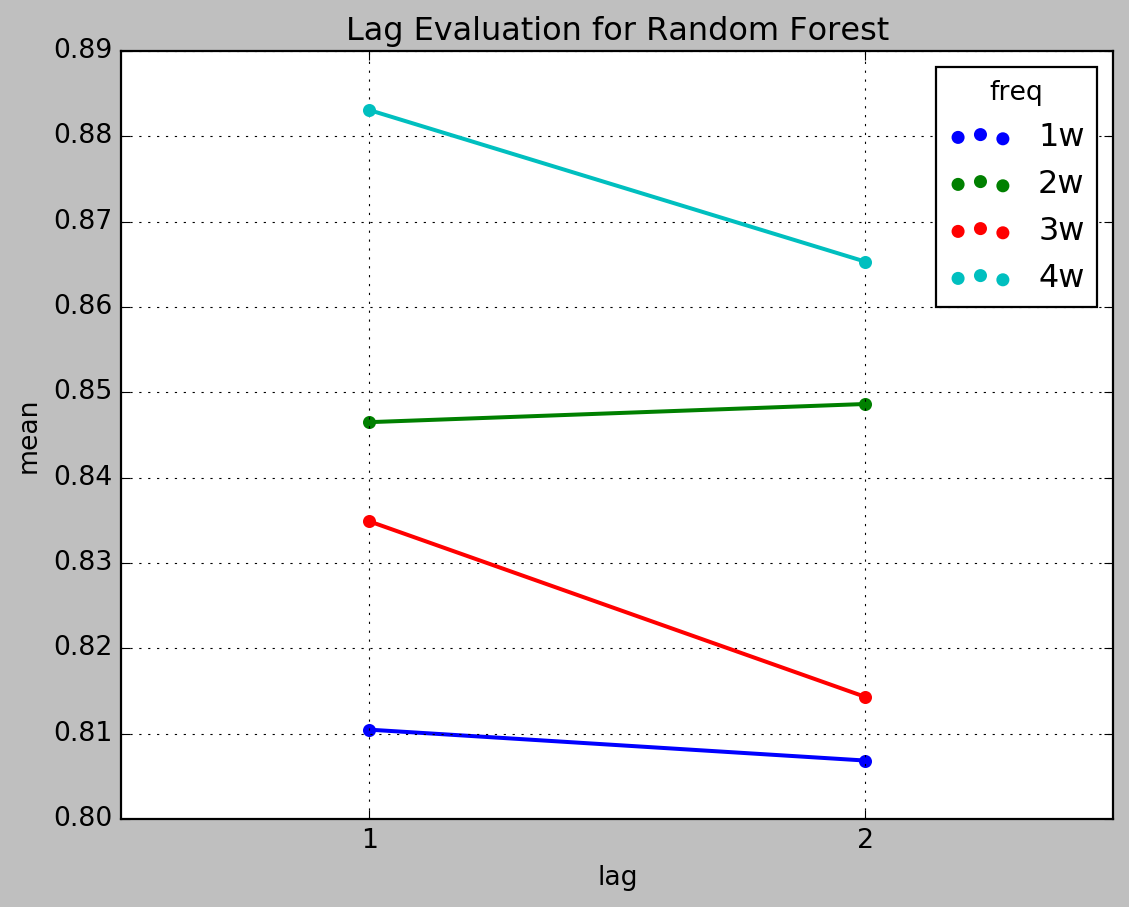

In [62]:
sns.pointplot(data=dat[(dat.model == "RF")], x="lag",y="mean",hue="freq")
plt.grid();plt.title("Lag Evaluation for Random Forest")

Text(0.5, 1.0, 'Lag Evaluation for VAR')

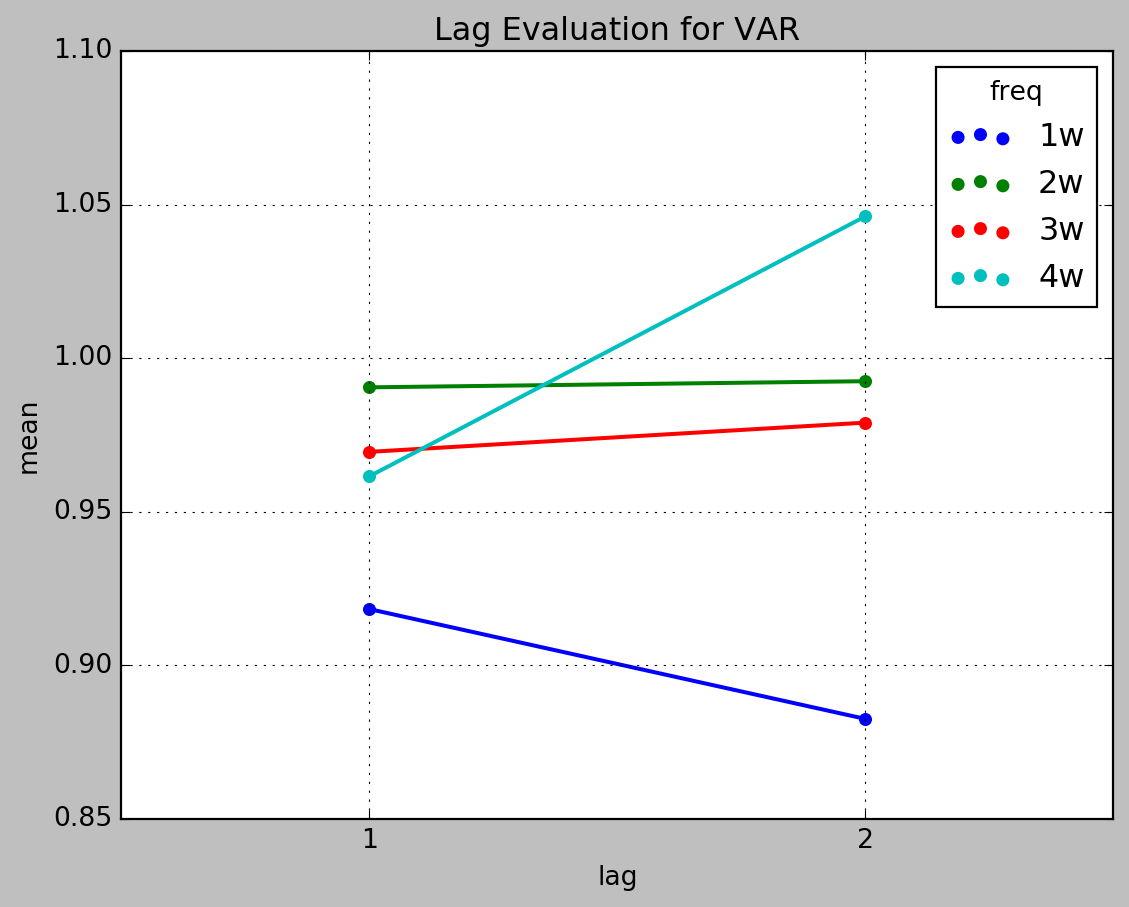

In [63]:
sns.pointplot(data=dat[(dat.model == "VAR")], x="lag",y="mean",hue="freq")
plt.grid();plt.title("Lag Evaluation for VAR")

Text(0.5, 1.0, 'Lag Evaluation for GVAR')

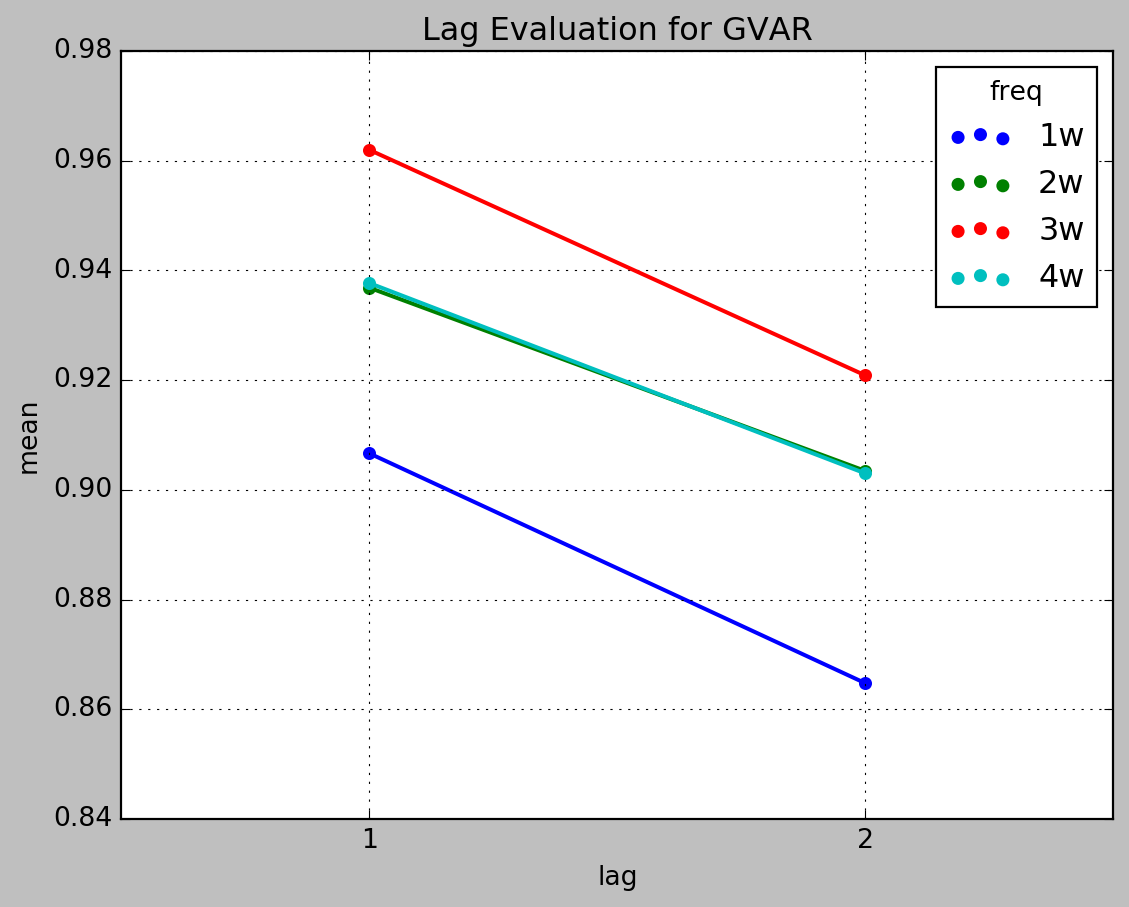

In [64]:
sns.pointplot(data=dat[(dat.model == "GVAR")], x="lag",y="mean",hue="freq")
plt.grid();plt.title("Lag Evaluation for GVAR")

Text(0.5, 1.0, 'Lag Evaluation for GRF')

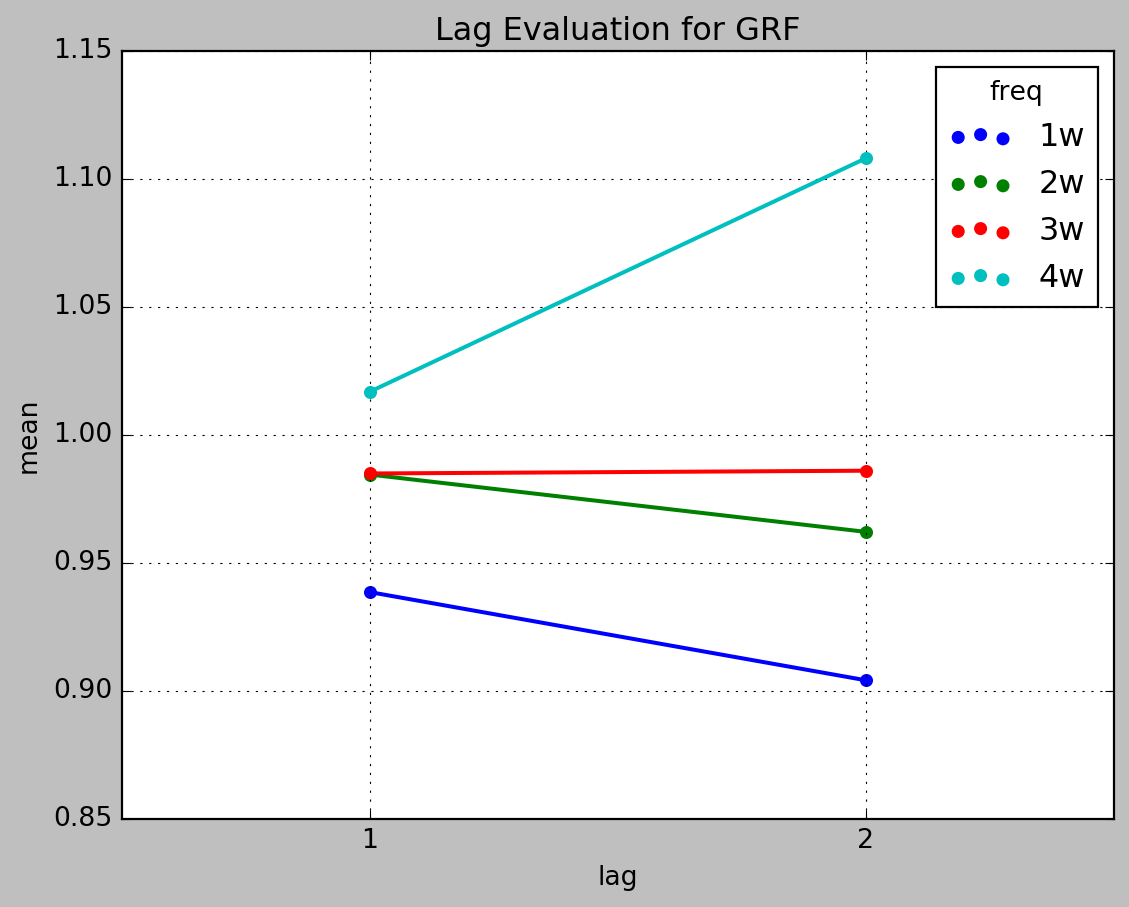

In [65]:
sns.pointplot(data=dat[(dat.model == "GRF")], x="lag",y="mean",hue="freq")
plt.grid();plt.title("Lag Evaluation for GRF")

Text(0.5, 1.0, 'Lag Evaluation for GRF_D')

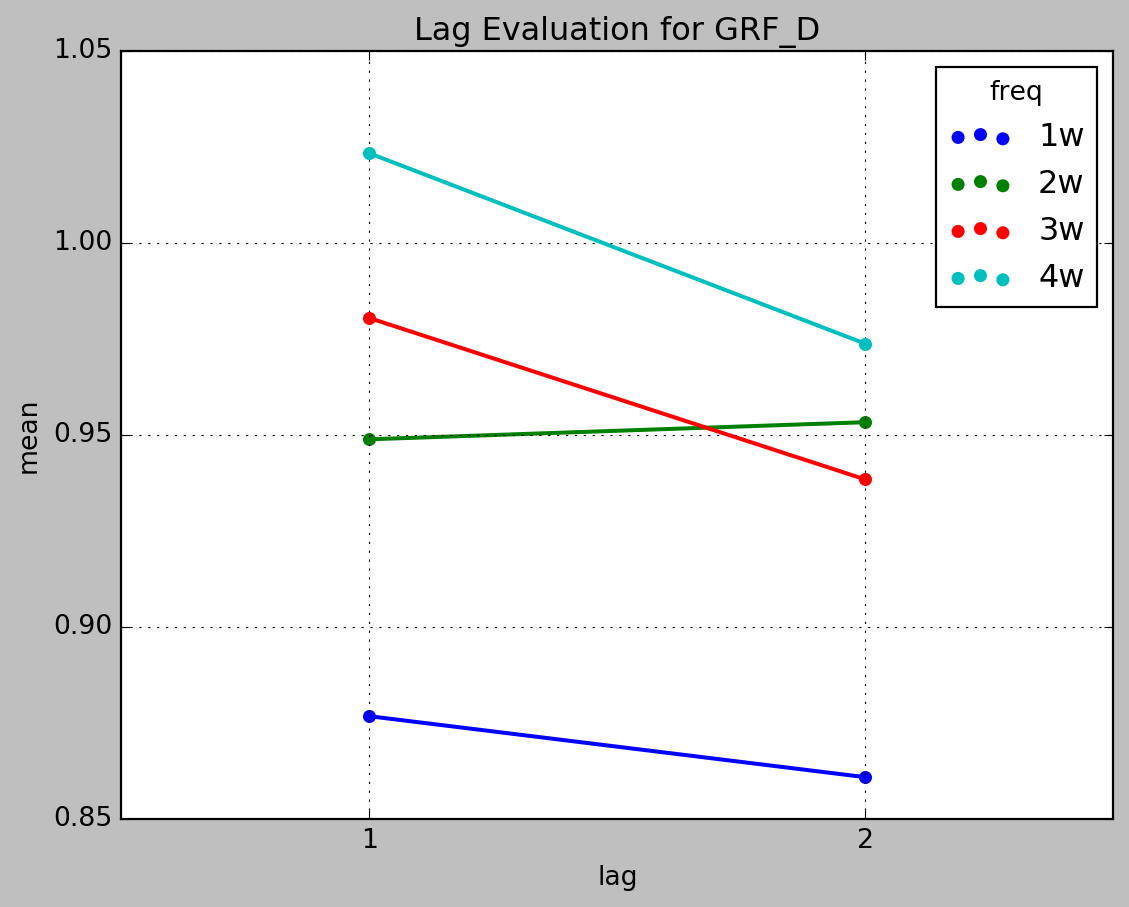

In [66]:
sns.pointplot(data=dat[(dat.model == "GRF_D")], x="lag",y="mean",hue="freq")
plt.grid();plt.title("Lag Evaluation for GRF_D")